# [IAPR 2020:][iapr2020] Lab 2 ‒  Object description

**Authors:** first_name_1 last_name_1, first_name_2 last_name_2, first_name_3 last_name_3  
**Due date:** 24.04.2020

[iapr2020]: https://github.com/LTS5/iapr-2020

## Extract relevant data
We first need to extract the `lab-02-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [1]:
import tarfile
import os

data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-02-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

## Part 1
In the `lab-02-data/part1` folder, you will find 28x28 grey-scale pictures of handwritten "0" and "1".
These digits have been extracted from MNIST dataset (http://yann.lecun.com/exdb/mnist/).

Your goal is to extract, from each of those images, a 2-dimensional feature vector (i.e. 2 features) and to plot them all on a 2D graph.
If you have chosen good features, the vectors of the "0"'s should nicely cluster in one part of the plane and those of the "1"'s in another.

Please try first the Fourier Descriptors.
You can make several attempts: e.g. with and without invariance to rotation, translation, scaling, etc.
You can also for instance rotate the images and assess the invariance in rotation.

**Note:** for the Fourier descriptors, the u_k signal has to be constructed by following the contour point after point.
Some pre-processing (image binarization, possibly some Mathematical Morphology) might be useful.

Then feel free to try other features, the more you try, the better it will be (for you).

### 1.1 Data visualization

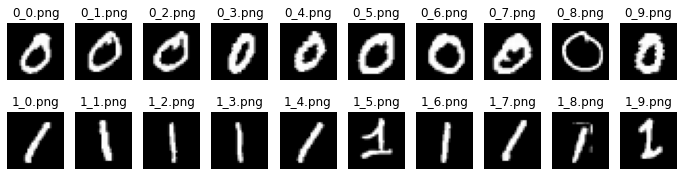

In [2]:
import skimage.io
import matplotlib.pyplot as plt
%matplotlib inline

# Load images
data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-02-data'
#  Load zeros
zeros_path = os.path.join(data_base_path, data_folder, 'part1', '0')
zeros_names = [nm for nm in os.listdir(zeros_path) if '.png' in nm]  # make sure to only load .png
zeros_names.sort()  # sort file names
ic = skimage.io.imread_collection([os.path.join(zeros_path, nm) for nm in zeros_names])
zeros_im = skimage.io.concatenate_images(ic)
#  Load ones
ones_path = os.path.join(data_base_path, data_folder, 'part1', '1')
ones_names = [nm for nm in os.listdir(ones_path) if '.png' in nm]  # make sure to only load .png
ones_names.sort()  # sort file names
ic = skimage.io.imread_collection(([os.path.join(ones_path, nm) for nm in ones_names]))
ones_im = skimage.io.concatenate_images(ic)

# Plot images
fig, axes = plt.subplots(2, len(zeros_im), figsize=(12, 3))
for ax, im, nm in zip(axes[0], zeros_im, zeros_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[1], ones_im, ones_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

### 1.2 Fourier descriptors
Add your implementation and discussion

In [3]:
import numpy as np
import matplotlib.pyplot as plt

from skimage import measure
from scipy import ndimage

from scipy.optimize import curve_fit
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.mixture import GaussianMixture

In [4]:
images = np.append(zeros_im,ones_im,axis = 0)

In [5]:
def threshold_detection(im):
    '''
    Simple threshold method detection.
    Assumption: The histogram of the inpute picture contains two distant maxima
    
    Input: 1 channel image
    output: binarization threshold
    '''
    hist , y = np.histogram(im.reshape(-1),bins=50)
    max_ = [-1,-1]
    indexes = [-1,-1]
    counter = 0
    for i in hist:
        if i >= min(max_):
            index_tmp = max_.index(min(max_))
            max_[index_tmp] = i
            indexes[index_tmp] = counter
        counter +=1
    
    return int(y[int(sum(indexes)/2)])

In [6]:
def binarization(im,threshold):
    '''
    Simple binarization function.
    Given a threshold, this function compute the corresponding binary image
    
    Input: 1 channel image, threshold
    Output: binary image
    '''
    im_tmp = im.reshape(-1)
    binary_image = np.zeros(im_tmp.shape)
    for i in range(im_tmp.shape[0]):
        if im_tmp[i] > threshold :
            binary_image[i]=1
            
    return binary_image.reshape(im.shape)

In [7]:
def low_pass_filter(img,size):
    Kernel = np.ones((size,size),np.float32)/size**2
    return ndimage.filters.convolve(img, Kernel)

In [22]:
def preprocessing(im):
    img = low_pass_filter(im,2)
    img_binary = binarization(img,threshold_detection(im))
    
    return img_binary

In [15]:
def complex_contour_vector(img,counter):
    
    preprocessed_img = preprocessing(img)
    contours = measure.find_contours(preprocessed_img, 0.8)
    
    non_complex_contour = []
    contour_tmp = []
    uk = []

    # creating a list with each image's first contour
    for n, ctr in enumerate(contours[0]):
        contour_tmp.append(ctr[0])
        contour_tmp.append(ctr[1])    
        uk.append(np.vectorize(complex)(ctr[0],ctr[1]))
        contour_tmp = []
        
    
    if counter < 10:
        for n, ctr in enumerate(contours[1]):
            contour_tmp.append(ctr[0])
            contour_tmp.append(ctr[1])    
            uk.append(np.vectorize(complex)(ctr[0],ctr[1]))
            contour_tmp = []
        
    uk = np.array(uk)
    
    return uk, contours

In [16]:
def dft_computation(img,n_descriptor=2):

    uk,_ = complex_contour_vector(img,counter)
    sp = np.fft.fft(uk)
    sp[n_descriptor:]=0
            
    return sp[0:n_descriptor]

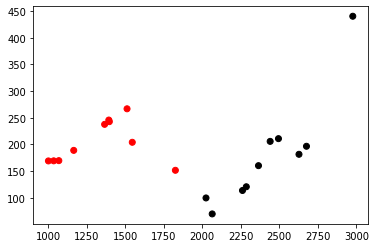

In [17]:
counter = 0
features = []
images = np.append(zeros_im,ones_im,axis = 0)
for im in images:
    sp = dft_computation(im)
    features.append(sp)
    counter += 1
features = np.array(features)
X = np.append(features.real,features.imag,axis=1)

kmeans = KMeans(n_clusters=2, random_state=0).fit(np.absolute(features))
kmeans.labels_
LABEL_COLOR_MAP = {0 : 'r', 1 : 'k'}
label_color = [LABEL_COLOR_MAP[l] for l in kmeans.labels_]
plt.scatter(np.absolute(features[:,0]),np.absolute(features[:,1]), c = label_color)

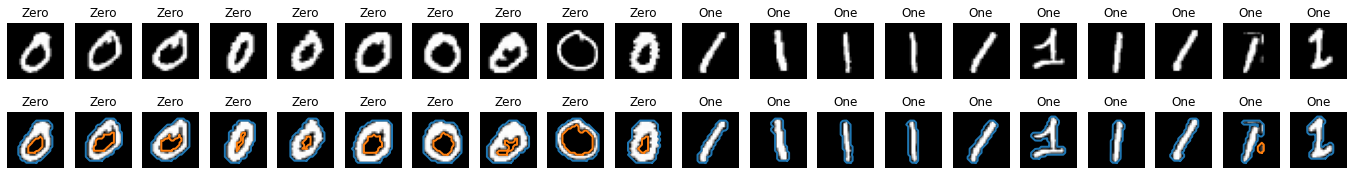

In [18]:
LABEL_NAME_MAP =  {0 : 'One', 1 : 'Zero'}
img_name = [LABEL_NAME_MAP[l] for l in kmeans.labels_]

fig, axes = plt.subplots(2, len(images), figsize=(24, 3))
for ax, im, nm in zip(axes[0], images, img_name):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
    
counter = 0    
for ax, im, nm in zip(axes[1], images, img_name):
    _, contours = complex_contour_vector(im,counter)
    ax.imshow(im, cmap='gray')
    
    counter += 1
    for n, ctr in enumerate(contours):
        ax.plot(ctr[:, 1], ctr[:, 0], linewidth=2)
            
    ax.axis('off')
    ax.set_title(nm)

# Problem: misclassification
## Solution:

- rajouter le contour interne au zéro => SOLUTION
- implémenter la morphologie mathématique
- essayer avec SVM ou gmm
- aller voir les autres githubs

### 1.3 Additional method(s)
Add your implementation and discussion

## Part 2
The `lab-02-data/part2` folder contains grey-scale pictures of handwritten "2" and "3".
Extract the same feature (typically 2 Fourier descriptors) as in part 1 also on these images and plot them on the same graph as the features of the "0" and "1".
Is it possible to discriminate all these 4 digits with a 2-dimensional feature vector?

### 2.1 Data visualization

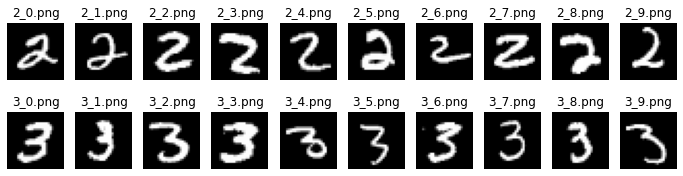

In [19]:
#  Load zeros
twos_path = os.path.join(data_base_path, data_folder, 'part2', '2')
twos_names = [nm for nm in os.listdir(twos_path) if '.png' in nm]  # make sure to only load .png
twos_names.sort()  # sort file names
ic = skimage.io.imread_collection([os.path.join(twos_path, nm) for nm in twos_names])
twos_im = skimage.io.concatenate_images(ic)
#  Load ones
threes_path = os.path.join(data_base_path, data_folder, 'part2', '3')
threes_names = [nm for nm in os.listdir(threes_path) if '.png' in nm]  # make sure to only load .png
threes_names.sort()  # sort file names
ic = skimage.io.imread_collection(([os.path.join(threes_path, nm) for nm in threes_names]))
threes_im = skimage.io.concatenate_images(ic)

# Plot images
fig, axes = plt.subplots(2, len(twos_im), figsize=(12, 3))
for ax, im, nm in zip(axes[0], twos_im, twos_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[1], threes_im, threes_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

### 2.2 Additional method(s) and conclusion
Add your implementations and discussions here

## Results:

- misclassified: 

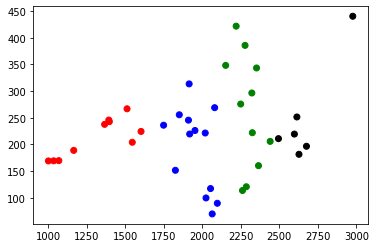

In [20]:
features = []
images = np.append(zeros_im,ones_im,axis = 0)
images = np.append(images,twos_im,axis = 0)
images = np.append(images,threes_im,axis = 0)

counter = 0
for im in images:
    sp = dft_computation(im)
    features.append(sp)
    counter += 1
    
features = np.array(features)
X = np.append(features.real,features.imag,axis=1)

kmeans = KMeans(n_clusters=4, random_state=0).fit(np.absolute(features))
kmeans.labels_
LABEL_COLOR_MAP = {0 : 'r', 1 : 'k', 2: 'b', 3: 'g'}
label_color = [LABEL_COLOR_MAP[l] for l in kmeans.labels_]
plt.scatter(np.absolute(features[:,0]),np.absolute(features[:,1]), c = label_color)

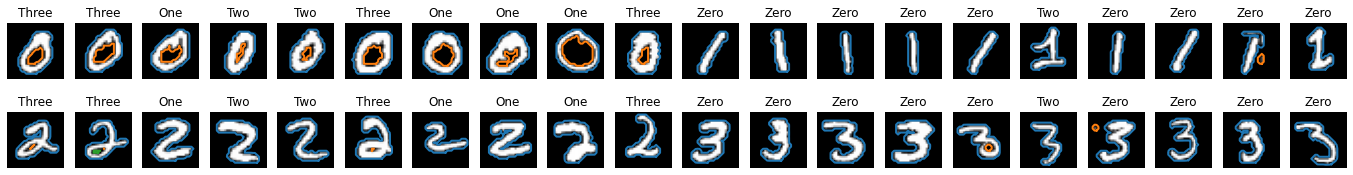

In [21]:
LABEL_NAME_MAP =  {0 : 'Zero', 1 : 'One', 2 : 'Two', 3 : 'Three'}
img_name = [LABEL_NAME_MAP[l] for l in kmeans.labels_]

images_first = np.append(zeros_im,ones_im,axis = 0)
images_second = np.append(twos_im,threes_im,axis = 0)
counter = 0 

fig, axes = plt.subplots(2, len(images_first), figsize=(24, 3))
for ax, im, nm in zip(axes[0], images_first, img_name):
    _, contours = complex_contour_vector(im,counter)
    ax.imshow(im, cmap='gray')
    
    counter += 1
    for n, ctr in enumerate(contours):
        ax.plot(ctr[:, 1], ctr[:, 0], linewidth=2)
            
    ax.axis('off')
    ax.set_title(nm)
    
for ax, im, nm in zip(axes[1], images_second, img_name):
    _, contours = complex_contour_vector(im,counter)
    ax.imshow(im, cmap='gray')
    
    counter += 1
    for n, ctr in enumerate(contours):
        ax.plot(ctr[:, 1], ctr[:, 0], linewidth=2)
            
    ax.axis('off')
    ax.set_title(nm)  

# Is a 2-dimensional feature vector enough to discriminate? Nope!